In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs 
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterfactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

2023-01-19 16:33:23.751590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:33:24.165589: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-19 16:33:24.318383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7h

TF version:  2.10.1
Eager execution enabled:  False


x_train shape: (60000, 28, 28) y_train shape: (60000,)


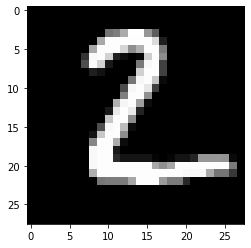

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [5]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5', save_format='h5')

2023-01-19 16:34:02.839894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:34:02.861880: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [7]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.988


In [8]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [9]:
ae, enc, dec = ae_model()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')
enc.save('mnist_enc.h5', save_format='h5')

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


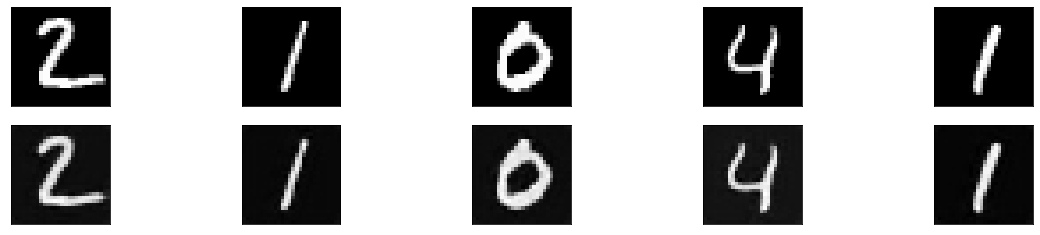

In [10]:
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5', compile=False)

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


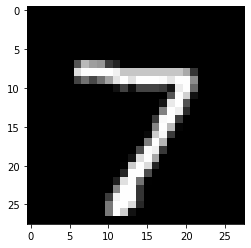

In [11]:
X = x_test[0].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

In [12]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

In [13]:
# initialize explainer, fit and generate counterfactual
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes
print('Time to find prototypes each class: {:.3f} sec'.format(time() - start_time))
start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Time to find prototypes each class: 5.708 sec
Explanation took 10.542 sec


Counterfactual prediction: 9
Closest prototype class: 9


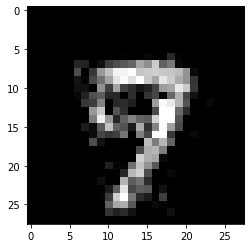

In [14]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

iteration c 0


The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


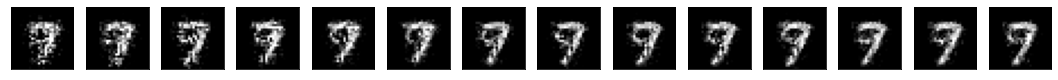

In [15]:
iter_cf = 0
print(f'iteration c {iter_cf}')
n = len(explanation['all'][iter_cf])
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n+1, i+1)
    plt.imshow(explanation['all'][iter_cf][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_k1 = cf.explain(X, k=1, k_type='mean')
explanation_k20 = cf.explain(X, k=20, k_type='mean')

Counterfactual prediction: 9
Closest prototype class: 9


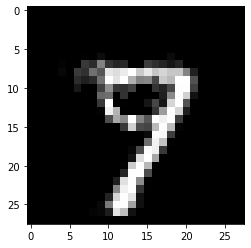

In [17]:
print('Counterfactual prediction: {}'.format(explanation_k1.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k1.cf['X'].reshape(28, 28));

Counterfactual prediction: 9
Closest prototype class: 9


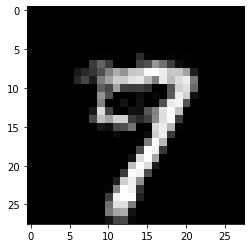

In [18]:
print('Counterfactual prediction: {}'.format(explanation_k20.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation_k20.cf['X'].reshape(28, 28));

In [19]:

# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 8.027 sec


Counterfactual prediction: 9
Closest prototype class: 9


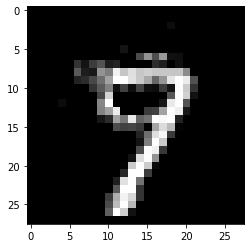

In [20]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

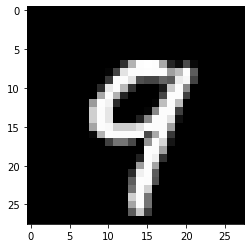

In [21]:
X = x_test[12].reshape((1,) + x_test[1].shape)
plt.imshow(X.reshape(28, 28));

In [22]:
# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
explanation_1 = cf.explain(X, k=5, k_type='mean')
proto_1 = explanation_1.id_proto
explanation_2 = cf.explain(X, k=5, k_type='mean', target_class=[7])
proto_2 = explanation_2.id_proto

Counterfactual prediction: 4
Closest prototype class: 4


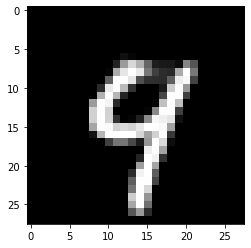

In [23]:
print('Counterfactual prediction: {}'.format(explanation_1.cf['class']))
print(f'Closest prototype class: {proto_1}')
plt.imshow(explanation_1.cf['X'].reshape(28, 28));

Counterfactual prediction: 7
Closest prototype class: 7


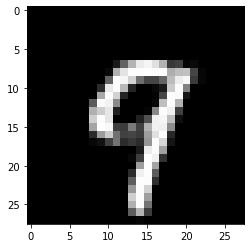

In [24]:
print('Counterfactual prediction: {}'.format(explanation_2.cf['class']))
print(f'Closest prototype class: {proto_2}')
plt.imshow(explanation_2.cf['X'].reshape(28, 28));

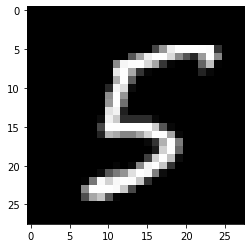

In [25]:
plt.gray()
X = x_test[23].reshape(1, 28, 28, 1)
plt.imshow(X.reshape(28, 28));

In [26]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 349.784 sec


Counterfactual prediction: 6
Closest prototype class: 6


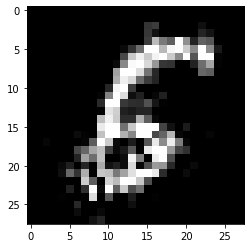

In [27]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

In [28]:
c_init = 1.
c_steps = 2

In [29]:
# define a black-box model
predict_fn = lambda x: cnn.predict(x)

# initialize explainer, fit and generate counterfactuals
cf = CounterfactualProto(predict_fn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
cf.fit(x_train)
start_time = time()
explanation = cf.explain(X, k=1)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 341.520 sec


Counterfactual prediction: 8
Closest prototype class: 6


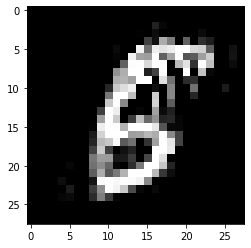

In [30]:
print('Counterfactual prediction: {}'.format(explanation.cf['class']))
print(f'Closest prototype class: {explanation.id_proto}')
plt.imshow(explanation.cf['X'].reshape(28, 28));